#0. DATASET CONTEXT

This dataset is cleaned from [an airline satisfaction survey](https:drive.google.com/file/d/1oKFnhKBtO_-eEYenjplsVJAzbcAOYspq/view).

The objective of this notebook is to create a model that will predict if the customer is satisfied or not.

#1. LIBRARIES NEEDED

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
import joblib
import os
import sys


import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import (VarianceThreshold, SelectKBest,
                                      f_classif, RFE, SelectFromModel)

from scipy.stats import randint

from sklearn.impute import SimpleImputer

print('✅ Libraries loaded')

✅ Libraries loaded


#2. DATASET LOADED

In [144]:
#Dataset load
df = pd.read_csv('airline-predict-g4-cleaning.csv')
print('✅ Dataset loaded')

✅ Dataset loaded


# 3. DATASET COPY

In [145]:
#In case any change is necessary
df_copy = df.copy()
print('✅ Copy done')

✅ Copy done


#4. DATA OVERVIEW

In [146]:
print('📋 DATASET INFORMATION')
first_rows = df_copy.head()
last_rows = df_copy.tail()
general_info = df_copy.info()

display(first_rows, last_rows, general_info)

📋 DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103594 entries, 0 to 103593
Data columns (total 29 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103594 non-null  int64  
 1   Gender                             103594 non-null  object 
 2   Customer Type                      103594 non-null  object 
 3   Age                                103594 non-null  int64  
 4   Type of Travel                     103594 non-null  object 
 5   Class                              103594 non-null  object 
 6   Flight Distance                    103594 non-null  int64  
 7   Inflight wifi service              103594 non-null  int64  
 8   Departure/Arrival time convenient  103594 non-null  int64  
 9   Ease of Online booking             103594 non-null  int64  
 10  Gate location                      103594 non-null  int64  
 11  Food and drink   

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Gender_label,Customer_label,Type_Travel_label,Satisfaction_label,Class_Ordinal
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,5,25,18.0,neutral or dissatisfied,1,0,1,0,1.0
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,4,1,1,6.0,neutral or dissatisfied,1,1,0,0,2.0
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,4,5,0,0.0,satisfied,0,0,0,1,2.0
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,4,2,11,9.0,neutral or dissatisfied,0,0,0,0,2.0
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,0,0.0,satisfied,1,0,0,1,2.0


,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Gender_label,Customer_label,Type_Travel_label,Satisfaction_label,Class_Ordinal
103589,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,...,3,2,3,0.0,neutral or dissatisfied,0,1,0,0,0.0
103590,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,...,5,4,0,0.0,satisfied,1,0,0,1,2.0
103591,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,...,5,4,7,14.0,neutral or dissatisfied,1,1,0,0,2.0
103592,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,...,4,1,0,0.0,neutral or dissatisfied,0,1,0,0,0.0
103593,62567,Male,Loyal Customer,27,Business travel,Business,1723,1,3,3,...,3,1,0,0.0,neutral or dissatisfied,1,0,0,0,2.0


None

Looking for the variables with most importance in this dataset an ANOVA is made. So we could compare a model with all the variables and only the top 10.

Variables after Varianza: 18
Variables after ANOVA: 10


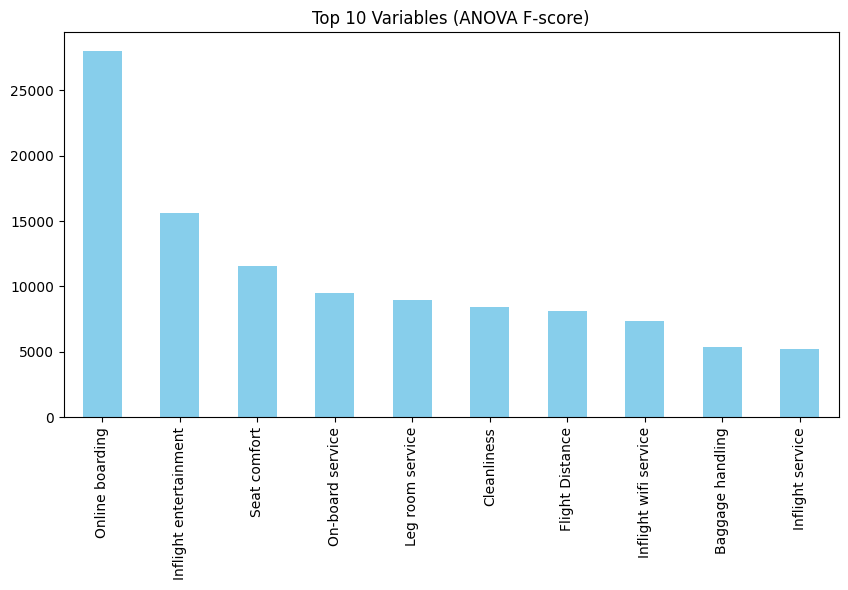

In [147]:
# 1. Filter by Varianza (Umbral de 0.01)
selector_var = VarianceThreshold(threshold=0.01)
X_train_var = selector_var.fit_transform(X_train)

# 2. Statistical filter (ANOVA) - TOP 10
selector_kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = selector_kbest.fit_transform(X_train, y_train)

print(f"Variables after Varianza: {X_train_var.shape[1]}")
print(f"Variables after ANOVA: {X_train_kbest.shape[1]}")

# Visualization
scores = pd.Series(selector_kbest.scores_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
scores.head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Variables (ANOVA F-score)")
plt.show()

#5. FEATURE ENGINEERING

In [148]:
#Numeric variables
NUMERIC_FEATURES = [
    'Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient',
    'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding',
    'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service',
    'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness',
    'Departure Delay in Minutes', 'Arrival Delay in Minutes'
]

#Categorical variables
CATEGORICAL_FEATURES = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

One Hot Encoding is applied to categorical variables. Categorical variables are standarised (mean = 0, std = 1).

In [149]:
# Define the numeric transformer pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define the categorical transformer pipeline
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess_ = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ]
)

Encoding (from string to number) so the model can use it.
Decoding (from number to string) so people can understand it.

In [150]:
def encode_target(y: pd.Series) -> np.ndarray:
    return y.map({'satisfied': 1, 'neutral or dissatisfied': 0}).values

def decode_target(y: np.ndarray) -> list:
    mapping = {1: 'satisfied', 0: 'neutral or dissatisfied'}
    return [mapping.get(val, "unknown") for val in y]

In [151]:
#Learning and transformation
transformed_data = preprocess_.fit_transform(df_copy[NUMERIC_FEATURES + CATEGORICAL_FEATURES])

# New columns created by OneHotEncoding
categorical_encoder = preprocess_.named_transformers_['cat']
columns_created = categorical_encoder.get_feature_names_out(CATEGORICAL_FEATURES)

print("\nColumns created by OneHotEncoding:")
for columna in columns_created:
    print(columna)


Columns created by OneHotEncoding:
Gender_Female
Gender_Male
Customer Type_Loyal Customer
Customer Type_disloyal Customer
Type of Travel_Business travel
Type of Travel_Personal Travel
Class_Business
Class_Eco
Class_Eco Plus


X (they are used for predict) and y (it is the one we want to predict) are defined.

In [152]:
X = df_copy[['Age','Flight Distance','Inflight wifi service',
        'Departure/Arrival time convenient','Ease of Online booking','Gate location','Food and drink','Online boarding','Seat comfort'
        ,'Inflight entertainment','On-board service','Leg room service','Baggage handling','Checkin service','Inflight service',
        'Cleanliness','Departure Delay in Minutes','Arrival Delay in Minutes']]
y = df_copy[['satisfaction']]


The data is split between train and test.

In [153]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
#80% for train y 20% for test
print(f"Train: {len(X_train)} samples ({len(X_train)/len(X)*100:.0f}%)")
print(f"Test: {len(X_test)} samples ({len(X_test)/len(X)*100:.0f}%)")

Train: 82875 samples (80%)
Test: 20719 samples (20%)


Optimization with optuna and the best parameters.

In [154]:
OPTUNA_AVAILABLE = True
X = df_copy[['Age','Flight Distance','Inflight wifi service',
        'Departure/Arrival time convenient','Ease of Online booking','Gate location','Food and drink','Online boarding','Seat comfort'
        ,'Inflight entertainment','On-board service','Leg room service','Baggage handling','Checkin service','Inflight service',
        'Cleanliness','Departure Delay in Minutes','Arrival Delay in Minutes']]
y = df_copy[['satisfaction']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Encode the target variable after splitting
y_train = encode_target(y_train['satisfaction'])
y_test = encode_target(y_test['satisfaction'])

resultado = optimize_with_optuna(X_train, y_train, X_test, y_test, n_trials = 10)
print(resultado)

[I 2026-02-16 22:28:50,015] A new study created in memory with name: no-name-2ca8e728-fb77-43fc-b574-c7618eaa470c



🔬 Optimizing with Optuna (10 trials)...


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-02-16 22:29:51,996] Trial 0 finished with value: 0.9399487686595241 and parameters: {'n_estimators': 144, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9399487686595241.
[I 2026-02-16 22:31:32,312] Trial 1 finished with value: 0.9375479257938011 and parameters: {'n_estimators': 267, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9399487686595241.
[I 2026-02-16 22:32:39,069] Trial 2 finished with value: 0.8942956846919762 and parameters: {'n_estimators': 95, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 0 with value: 0.9399487686595241.
[I 2026-02-16 22:33:02,493] Trial 3 finished with value: 0.9169544555705953 and parameters: {'n_estimators': 85, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9399487686595241.


Training RandomForest with the best parameters.

In [155]:
#Best parameters
best_params = study_rf.best_params
print(best_params)

#Model
model = RandomForestClassifier(**best_params)

#Training
model.fit(X_train, y_train)

#Testing
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#Metrics
metrics = calculate_metrics(y_train, y_train_pred, y_test, y_test_pred, "Optuna Optimized")

print(metrics)

{'n_estimators': 258, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 1}
{'model_name': 'Optuna Optimized', 'train': {'accuracy': 0.9804645550527904, 'precision': 0.9887435003714073, 'recall': 0.9658136354756789, 'f1': 0.9771440671984188}, 'test': {'accuracy': 0.9494666731019837, 'precision': 0.9605883028840629, 'recall': 0.9223300970873787, 'f1': 0.9410705240051781}, 'overfitting': {'accuracy_diff': 0.03099788195080666, 'f1_diff': 0.03607354319324074, 'is_overfitting': False}}


In [156]:

    metrics = {
        'model_name': model,
        'train': {
            'cm_rf': confusion_matrix(y_train, y_train_pred),
            'accuracy': accuracy_score(y_train, y_train_pred),
            'precision': precision_score(y_train, y_train_pred),
            'recall': recall_score(y_train, y_train_pred),
            'f1': f1_score(y_train, y_train_pred)
        },
        'test': {
            'cm_rf': confusion_matrix(y_test, y_test_pred),
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred),
            'recall': recall_score(y_test, y_test_pred),
            'f1': f1_score(y_test, y_test_pred)
        }
    }

     # Overfitting Check
    metrics['overfitting'] = {
        'cm_rf': metrics['train']['cm_rf'] - metrics['test']['cm_rf'],
        'accuracy_diff': metrics['train']['accuracy'] - metrics['test']['accuracy'],
        'f1_diff': metrics['train']['f1'] - metrics['test']['f1'],
        'is_overfitting': (metrics['train']['accuracy'] - metrics['test']['accuracy']) > 0.05
    }

    print(metrics_test_train)
    display(metrics['overfitting'])

{'model_name': RandomForestClassifier(max_depth=17, min_samples_split=6, n_estimators=258), 'train': {'accuracy': 0.9802835595776772, 'precision': 0.988431546173841, 'recall': 0.9657020065302933, 'f1': 0.9769345868270235}, 'test': {'accuracy': 0.9488392296925527, 'precision': 0.9597886029411765, 'recall': 0.9216681376875552, 'f1': 0.9403421882035119}}


{'cm_rf': array([[35336,    51],
        [  521, 26248]]),
 'accuracy_diff': 0.03099788195080666,
 'f1_diff': 0.03607354319324074,
 'is_overfitting': False}

In [157]:
    print(f"\n📊 METRICS: {metrics['model_name']}")
    print("=" * 50)

    print("\n🔹 TRAIN:")
    for metric, value in metrics['train'].items():
        if metric == 'cm_rf':  # Handle confusion matrix separately
            print(f"   {metric.capitalize():12}:\n{value}")
        else:
            print(f"   {metric.capitalize():12}: {value:.4f}")

    print("\n🔹 TEST:")
    for metric, value in metrics['test'].items():
        if metric == 'cm_rf':  # Handle confusion matrix separately
            print(f"   {metric.capitalize():12}:\n{value}")
        else:
            print(f"   {metric.capitalize():12}: {value:.4f}")

    print("\n🔍 OVERFITTING CHECK:")
    diff_acc = metrics['overfitting']['accuracy_diff']
    status = "⚠️ OVERFITTING DETECTED" if metrics['overfitting']['is_overfitting'] else "✅ OK"

    print(f"   Accuracy Diff: {diff_acc:.4f} ({diff_acc*100:.2f}%)")
    print(f"   Status: {status}")


📊 METRICS: RandomForestClassifier(max_depth=17, min_samples_split=6, n_estimators=258)

🔹 TRAIN:
   Cm_rf       :
[[46648   394]
 [ 1225 34608]]
   Accuracy    : 0.9805
   Precision   : 0.9887
   Recall      : 0.9658
   F1          : 0.9771

🔹 TEST:
   Cm_rf       :
[[11312   343]
 [  704  8360]]
   Accuracy    : 0.9495
   Precision   : 0.9606
   Recall      : 0.9223
   F1          : 0.9411

🔍 OVERFITTING CHECK:
   Accuracy Diff: 0.0310 (3.10%)
   Status: ✅ OK


We save the model.

In [158]:
joblib.dump(model, 'airline-predict-g4-model_done.joblib')
print("Saved as 'airline-predict-g4-model_done'")

#Download (delete # in the next line)
# files.download('airline-predict-g4-modeldone.joblib')

Saved as 'airline-predict-g4-model_done'
